###  Install and import feedback gadget


In [1]:
# @title Project Background

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

from IPython.display import Image, display
import os
from pathlib import Path

In [2]:
# @markdown Local installation

import contextlib
import io
import os

In [3]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging


# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(2024)

dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

ComputationThruDynamicsBenchmark/


In [4]:
import torch
device = torch.device("mps")

In [5]:

from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
from ctd.task_modeling.task_env.task_env import RandomTarget
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper

### CO GRU 6 latent units

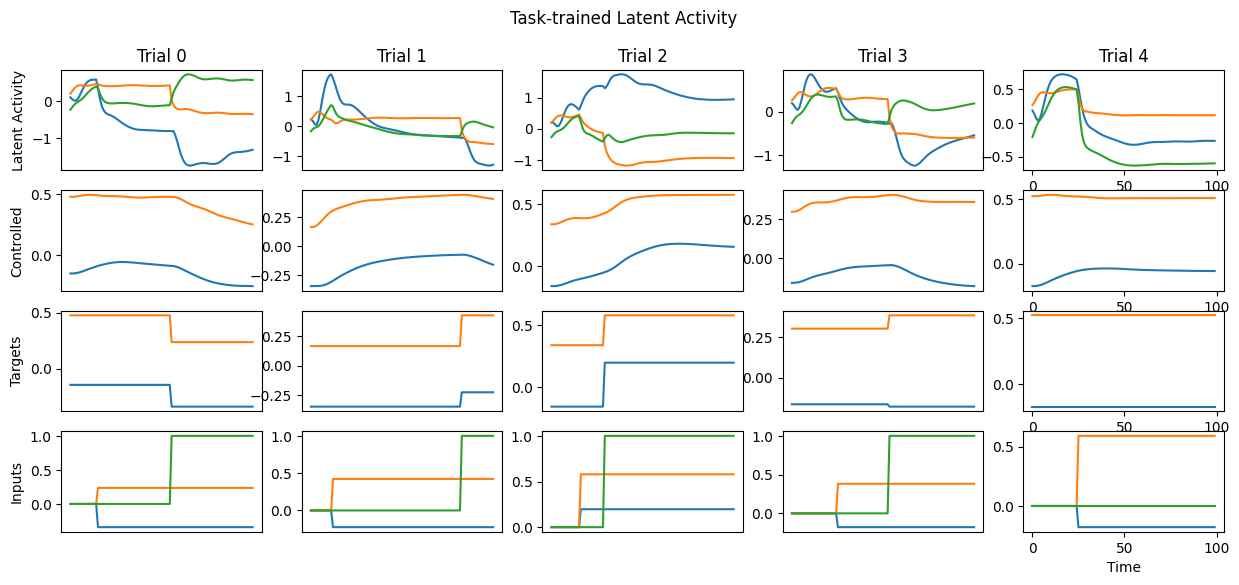

In [6]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_CO_GRU_128 = HOME_DIR + "models_CO_GRU_128/"
# Create the analysis object:
analysis_CO_GRU_128 = TT_RandomTarget(
    run_name = "CenterOut GRU_128",
    filepath = fpath_CO_GRU_128)

analysis_CO_GRU_128.plot_trial_io(num_trials = 5)

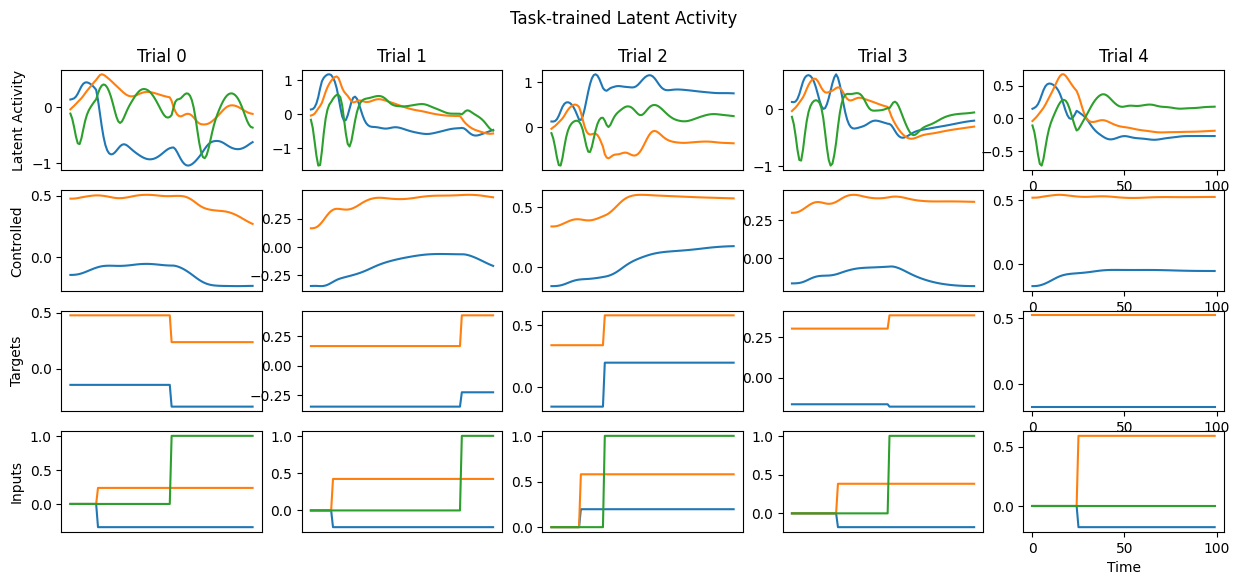

In [7]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_CO_LSTM_128 = HOME_DIR + "models_CO_LSTM_128/"
# Create the analysis object:
analysis_CO_LSTM_128 = TT_RandomTarget(
    run_name = "CenterOut LSTM_128",
    filepath = fpath_CO_LSTM_128)

analysis_CO_LSTM_128.plot_trial_io(num_trials = 5)

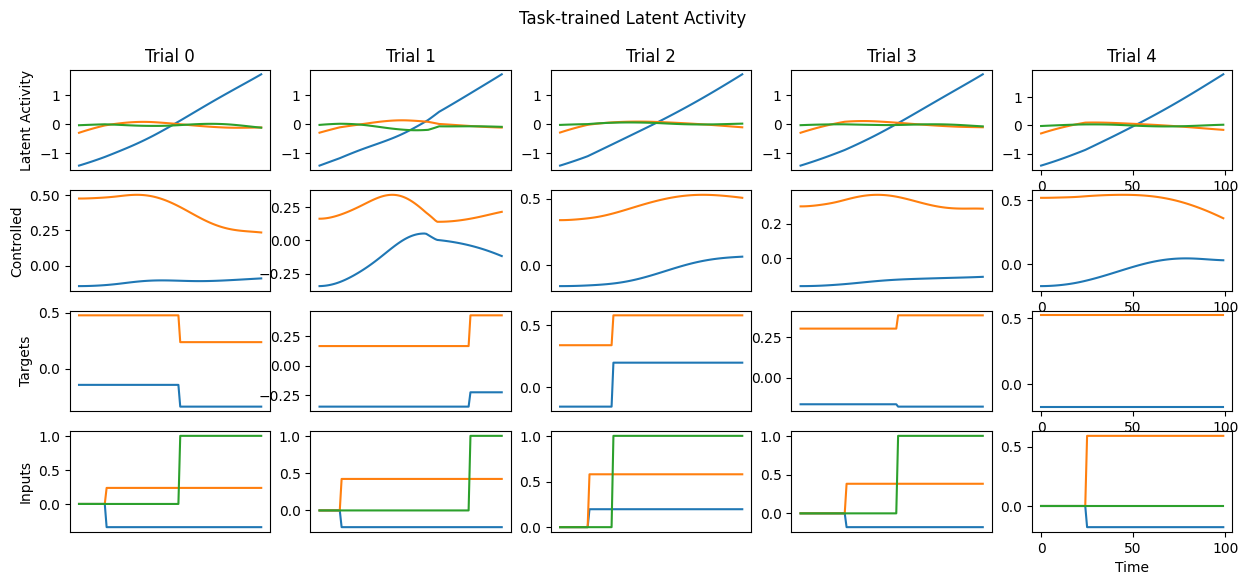

In [8]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_CO_NODE_6 = HOME_DIR + "models_CO_NODE_6/"
# Create the analysis object:
analysis_CO_NODE_6 = TT_RandomTarget(
    run_name = "CenterOut NODE_6",
    filepath = fpath_CO_NODE_6)

analysis_CO_NODE_6.plot_trial_io(num_trials = 5)

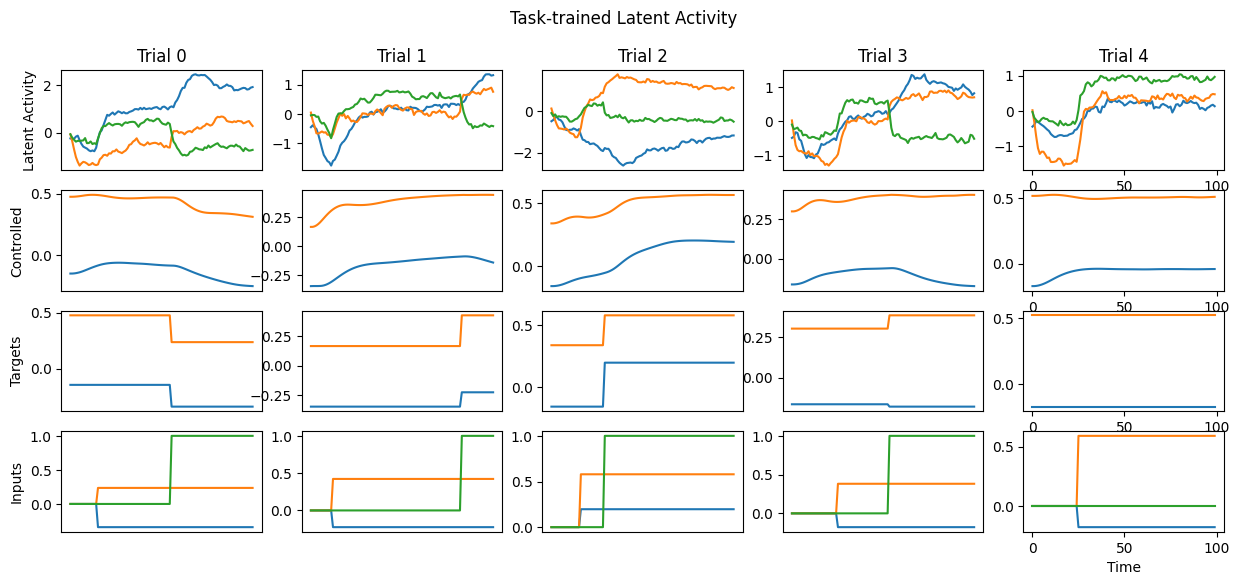

In [9]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_CO_NoisyGRU_128 = HOME_DIR + "models_CO_NoisyGRU_128/"
# Create the analysis object:
analysis_CO_NoisyGRU_128 = TT_RandomTarget(
    run_name = "CenterOut NoisyGRU_128",
    filepath = fpath_CO_NoisyGRU_128)

analysis_CO_NoisyGRU_128.plot_trial_io(num_trials = 5)

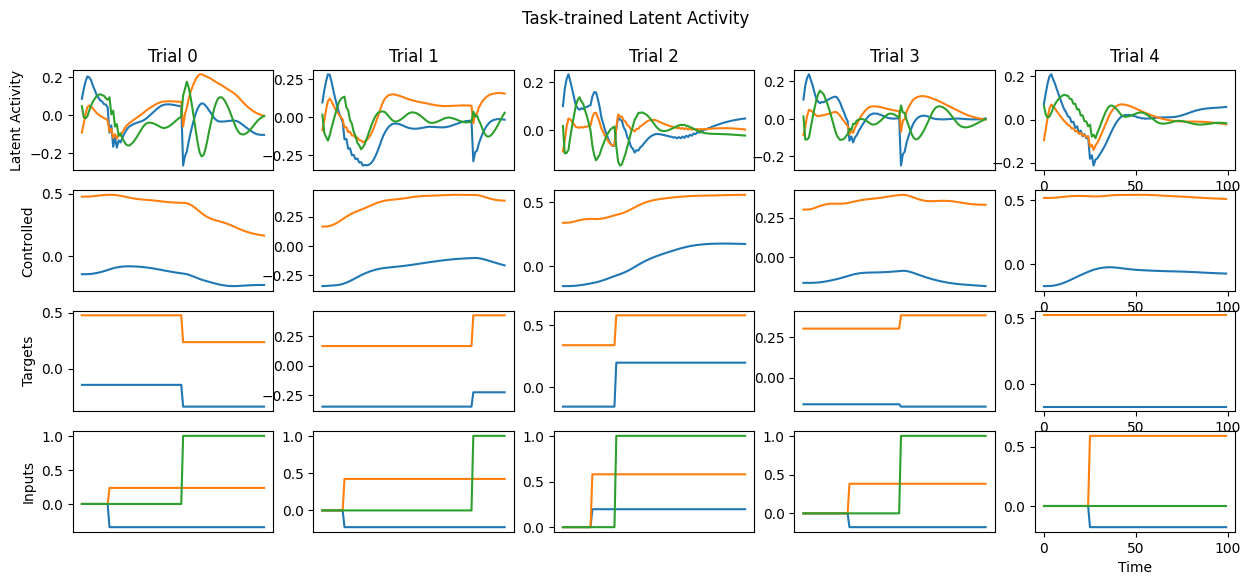

In [10]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_CO_NODE_128 = HOME_DIR + "models_CO_NODE_128/"
# Create the analysis object:
analysis_CO_NODE_128 = TT_RandomTarget(
    run_name = "CenterOut NODE_128",
    filepath = fpath_CO_NODE_128)

analysis_CO_NODE_128.plot_trial_io(num_trials = 5)

In [21]:


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_CO_GRU_128
target = analysis_CO_NODE_128

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape} {latents_source_val.shape}"
      f"\nLatent shape for target model: {latents_targ.shape} {latents_targ_val.shape}")

# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials_val, n_timesteps_val, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")
co_node_128_r2 = r2_var

Latent shape for source model: (800, 100, 128) (200, 100, 128)
Latent shape for target model: (800, 100, 6) (200, 100, 6)
R2 of linear regression fit: [0.7864491 0.5382035 0.5291515 0.6253171 0.3589881 0.4845065]
Variance-weighted R2 of linear regression fit: 0.6550005674362183


In [16]:


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_CO_NODE_6
target = analysis_CO_GRU_128

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape} {latents_source_val.shape}"
      f"\nLatent shape for target model: {latents_targ.shape} {latents_targ_val.shape}")

# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials_val, n_timesteps_val, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")
co_gru_128_r2 = r2_var

Latent shape for source model: (800, 100, 6) (200, 100, 6)
Latent shape for target model: (800, 100, 128) (200, 100, 128)
R2 of linear regression fit: [ 4.31918740e-01  3.53920996e-01  7.23996162e-02  2.07000256e-01
  4.46630478e-01  2.65686512e-02  9.44435596e-03  5.82211018e-02
  4.80729938e-02  2.40211487e-02  3.38020325e-02  1.14567161e-01
  9.06952620e-02  2.07507610e-03  4.67559695e-02  4.17400599e-02
  3.11799645e-02  4.46438789e-03  3.64101529e-02  3.95240784e-02
  6.84696436e-03  1.27085447e-02  1.87547803e-02  3.15761566e-03
  3.23647261e-03  1.91083550e-02  1.13186240e-02  1.81415677e-02
  1.48522854e-02  4.85624075e-02  3.75103951e-03  8.85188580e-04
  3.66526842e-03  4.47183847e-03  2.85732746e-03 -7.59446621e-03
  2.31382251e-02  3.66443396e-03  1.13191009e-02  2.10547447e-03
 -1.00600719e-03  1.57779455e-03  9.15086269e-03  1.31773949e-03
  7.21019506e-03  6.28495216e-03  1.76626444e-03  6.20585680e-03
  5.37371635e-03 -8.22544098e-05  6.66797161e-04  3.90237570e-03
  5.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_CO_GRU_128
target = analysis_CO_NoisyGRU_128

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape} {latents_source_val.shape}"
      f"\nLatent shape for target model: {latents_targ.shape} {latents_targ_val.shape}")

# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials_val, n_timesteps_val, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")
co_noisygru_128_r2 = r2_var

Latent shape for source model: (800, 100, 128) (200, 100, 128)
Latent shape for target model: (800, 100, 128) (200, 100, 128)
R2 of linear regression fit: [ 9.87958610e-01  9.82877553e-01  9.68434274e-01  8.88527751e-01
  8.45066845e-01  8.36915314e-01  8.00593197e-01  7.11542249e-01
  6.69419289e-01  5.76794028e-01  5.38985431e-01  4.41479743e-01
  4.06956315e-01  2.61264026e-01  2.92790651e-01  2.12385714e-01
  7.06436038e-02  1.79017782e-01  1.28281891e-01  8.29762816e-02
  8.42919946e-02  6.34902120e-02  5.32711148e-02  3.65794301e-02
  3.93513441e-02  1.65500641e-02  2.17286348e-02  1.36013627e-02
  2.78346539e-02  1.06465220e-02  2.01230645e-02  8.06123018e-03
  1.31114721e-02  1.63094401e-02  8.75771046e-03  8.10867548e-03
  1.34976506e-02  1.69710517e-02  5.61612844e-03  1.20416284e-02
  2.44671106e-03  5.32609224e-03  4.19259071e-03  7.14302063e-03
  6.31767511e-03  1.62398815e-03  4.61900234e-03  4.47833538e-03
  6.33496046e-03  3.49408388e-03  3.20529938e-03  2.86203623e-03


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_CO_GRU_128
target = analysis_CO_LSTM_128

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape} {latents_source_val.shape}"
      f"\nLatent shape for target model: {latents_targ.shape} {latents_targ_val.shape}")

# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials_val, n_timesteps_val, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")
co_lstm_128_r2 = r2_var

Latent shape for source model: (800, 100, 128) (200, 100, 128)
Latent shape for target model: (800, 100, 128) (200, 100, 128)
R2 of linear regression fit: [0.9599895  0.9106132  0.73016787 0.8854808  0.72016776 0.9209254
 0.6803236  0.79401004 0.7673461  0.5744896  0.64486027 0.6543642
 0.7433069  0.6269672  0.5497086  0.61195344 0.64718616 0.4416843
 0.5832398  0.5057254  0.5125363  0.49138206 0.44652176 0.5789894
 0.4727664  0.50573856 0.58129877 0.4423604  0.5619066  0.3741833
 0.4913209  0.392704   0.499429   0.40713042 0.45903182 0.44651115
 0.362822   0.4362083  0.42188984 0.51678    0.36296695 0.384921
 0.3478698  0.35802364 0.31700522 0.33725804 0.3410101  0.45592344
 0.4221223  0.27483064 0.32860118 0.4256515  0.28287423 0.3031965
 0.3323086  0.3205372  0.31799316 0.29837966 0.23836297 0.2770297
 0.32968497 0.31201392 0.31412053 0.20237458 0.2095524  0.27807426
 0.26445037 0.33097947 0.28793478 0.24040645 0.20402789 0.28210998
 0.25076246 0.27443057 0.244605   0.15110534 0.152

In [11]:
import matplotlib.pyplot as plt

0.6550005674362183 0.8430590629577637 0.8543275594711304
Hello World
Hello World
Hello World
Hello World


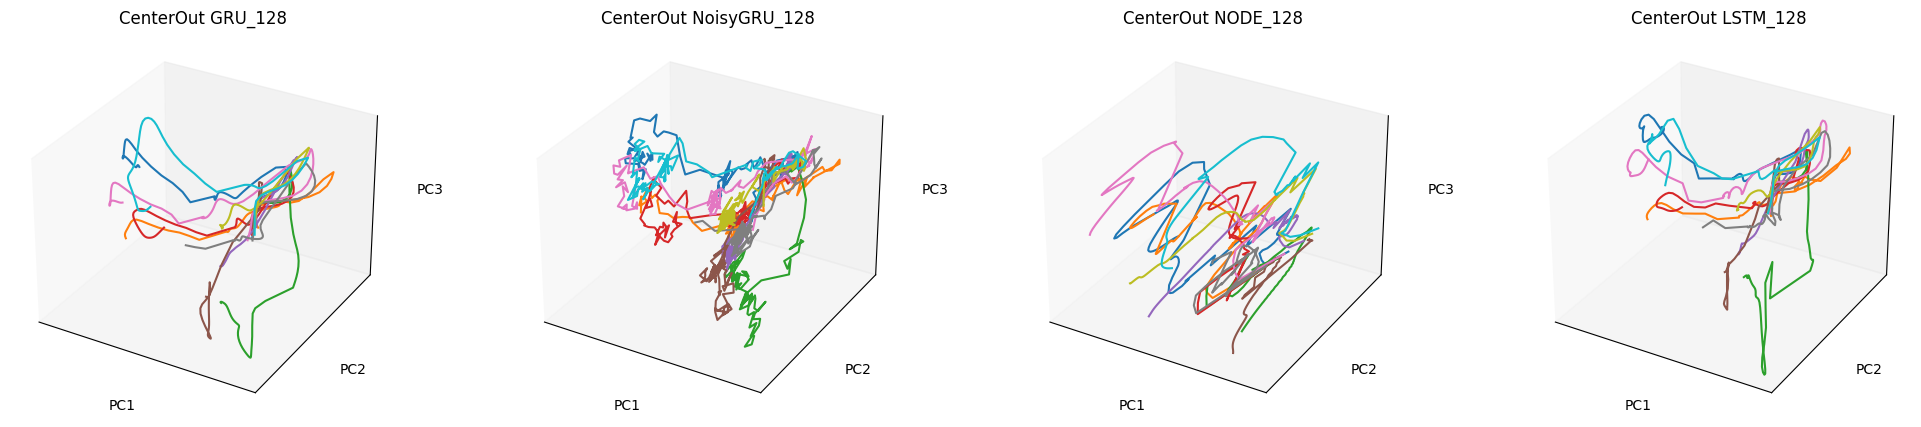

In [24]:
from ctd.comparison.comparison import Comparison
# fig = plt.figure(figsize=(4,20))
print(
    co_node_128_r2,
# co_gru_128_r2,
co_noisygru_128_r2,
co_lstm_128_r2
     )
comp = Comparison()
# comp.load_analysis(analysis_CO_NODE_6, reference_analysis=True)
comp.load_analysis(analysis_CO_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_CO_NoisyGRU_128)
comp.load_analysis(analysis_CO_NODE_128)
comp.load_analysis(analysis_CO_LSTM_128)
comp.plot_trials_3d_reference(num_trials=10)
plt.savefig('CO_latent_size_128.png', bbox_inches='tight', dpi=300)

In [ ]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_co_gru = analysis_CO_GRU_6.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-6,
        noise_scale=0.0,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-2,
    )

### RT LSTM 128 latent units

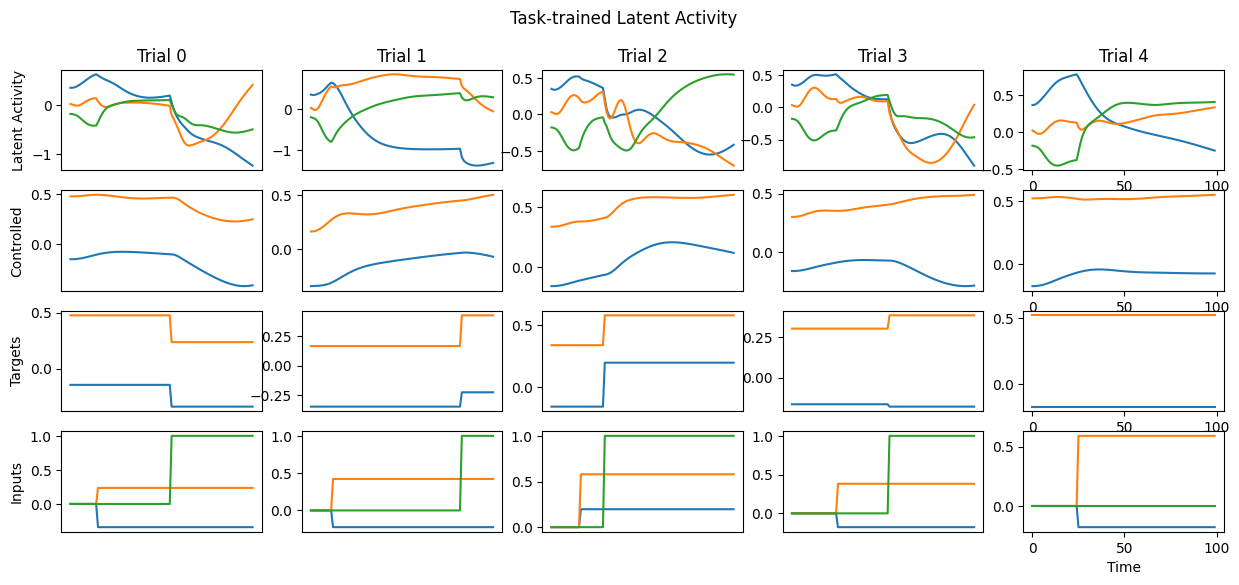

In [7]:

fpath_RT_LSTM_128 = HOME_DIR + "models_RT_LSTM_128/"
# Create the analysis object:
analysis_RT_LSTM_128 = TT_RandomTarget(
    run_name = "RT_LSTM_128",
    filepath = fpath_RT_LSTM_128)

analysis_RT_LSTM_128.plot_trial_io(num_trials = 5)

### Affine transform of the PCs of the latent space between the two models (LSTM 6 and LSTM 128) doing RandomTarget Task

In [ ]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_RT_LSTM_6)
comp.load_analysis(analysis_RT_LSTM_128, reference_analysis=True) #source is 128 latent space
comp.plot_trials_3d_reference(num_trials=10)

Latent shape for source model: (800, 100, 128)
Latent shape for target model: (800, 100, 6)
R2 of linear regression fit: [0.9278175  0.910594   0.8596909  0.8234477  0.8207369  0.83728063]
Variance-weighted R2 of linear regression fit: 0.9054650068283081


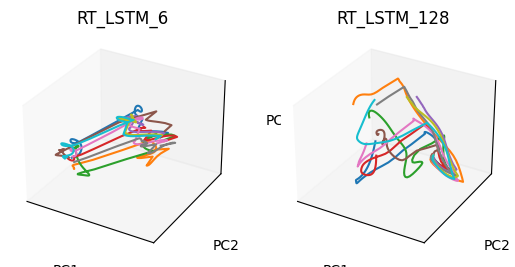

In [8]:


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_RT_LSTM_128
target = analysis_RT_LSTM_6

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")

# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

#### R2 of fit is very high (0.9) it makes sense since the model architecture is the same(both are LSTM) and the task is the same (both doing RandomTarget task)

## Visualize fixed point

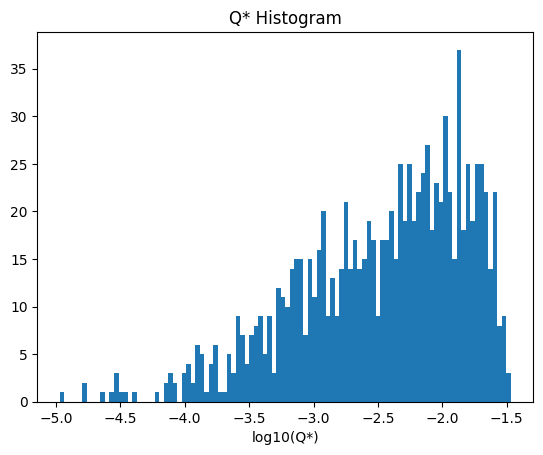

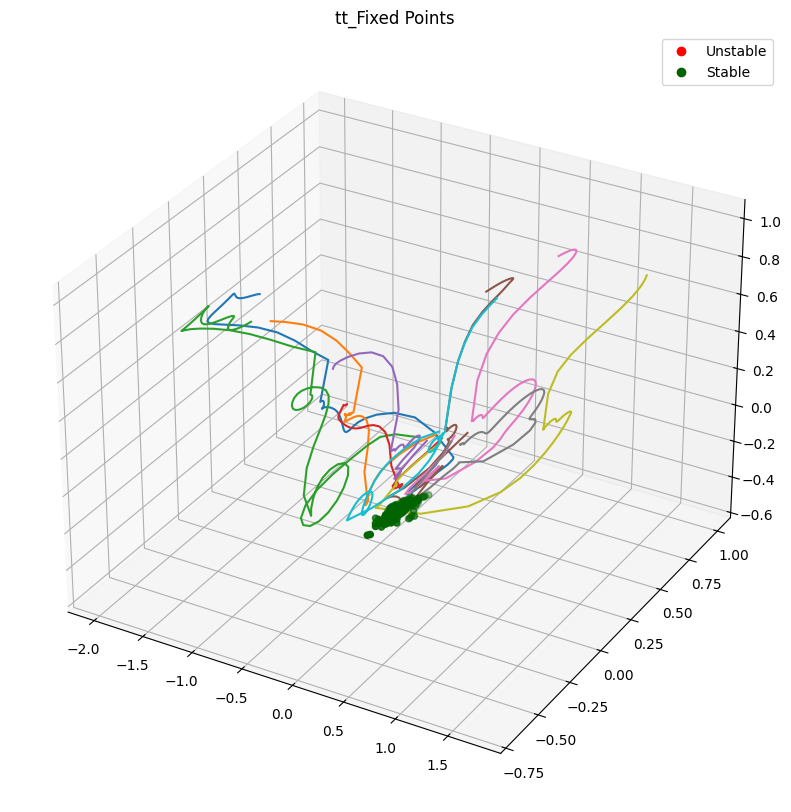

In [25]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_CO_GRU_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-6,
        noise_scale=0.0,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-3,
    )

In [ ]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_CO_NODE_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-6,
        noise_scale=0.0,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-3,
    )

## GRU latent 6

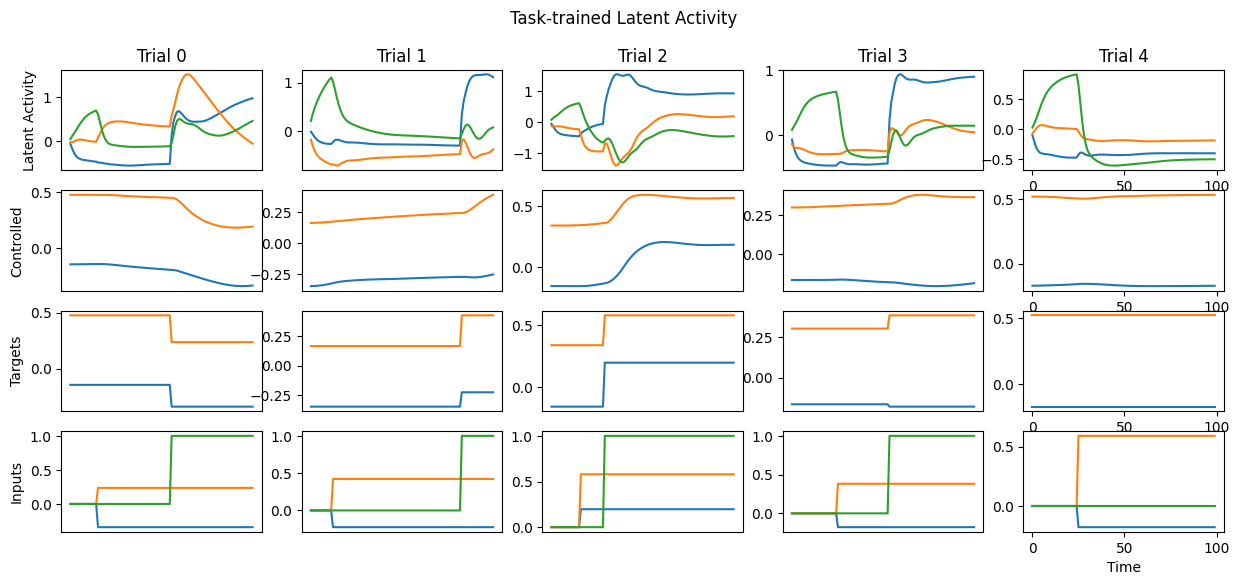

In [12]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_RT_GRU_128 = HOME_DIR + "models_RT_GRU_128/"
# Create the analysis object:
analysis_RT_GRU_128 = TT_RandomTarget(
    run_name = "RT_GRU_128",
    filepath = fpath_RT_GRU_128)

analysis_RT_GRU_128.plot_trial_io(num_trials = 5)

### Find the fixed points for the GRU RNN doing RandomTask

In [ ]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_rt_gru_128 = analysis_RT_GRU_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-8,
        noise_scale=0.01,
        max_iters=2000000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-3,
    )

In [ ]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_CO_GRU_128 = HOME_DIR + "models_CO_GRU_128/"
# Create the analysis object:
analysis_CO_GRU_128 = TT_RandomTarget(
    run_name = "CO_GRU_128",
    filepath = fpath_CO_GRU_128)

analysis_CO_GRU_128.plot_trial_io(num_trials = 5)

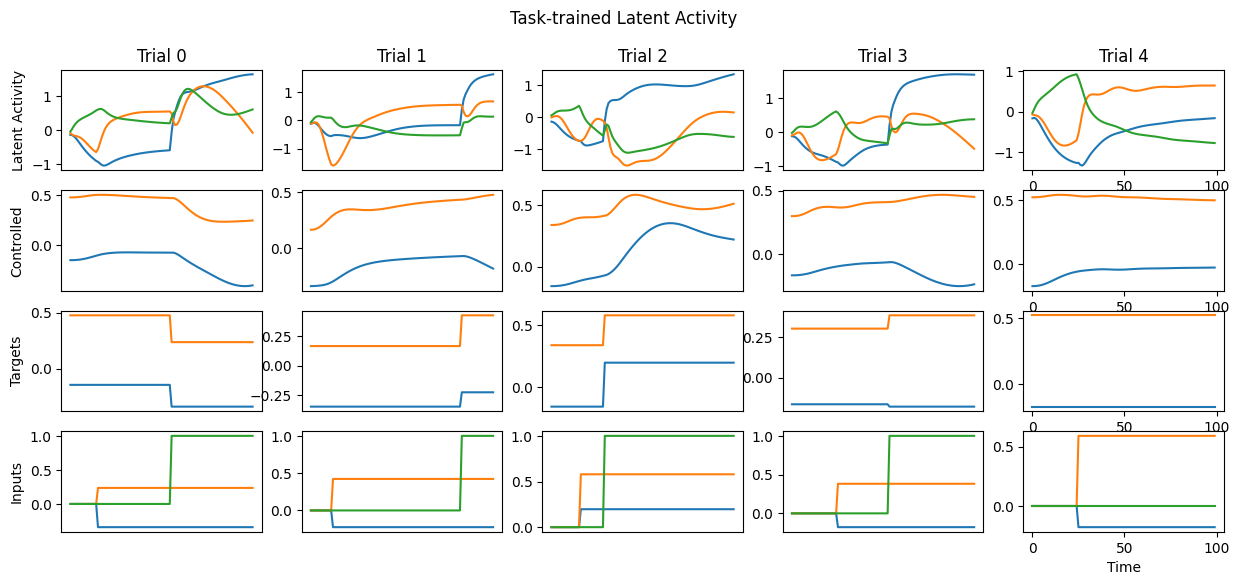

In [7]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_CO_GRU_128 = HOME_DIR + "models_CO_GRU_128/"
# Create the analysis object:
analysis_CO_GRU_128 = TT_RandomTarget(
    run_name = "CO_GRU_128",
    filepath = fpath_CO_GRU_128)

analysis_CO_GRU_128.plot_trial_io(num_trials = 5)

In [7]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_GRU_128_RT = HOME_DIR + "models_GRU_128_RT/"
# Create the analysis object:
analysis_GRU_128_RT = TT_RandomTarget(
    run_name = "GRU_128_RT",
    filepath = fpath_GRU_128_RT)

analysis_GRU_128_RT.plot_trial_io(num_trials = 5)

EOFError: Ran out of input

In [60]:
fpath_NODE = HOME_DIR + "models_RT_GRU_128/"

# Create the analysis object:
analysis_GRU_128 = TT_RandomTarget(
    run_name = "GRU_128_RT",
    filepath = fpath_NODE)

analysis_NODE.plot_trial_io(num_trials = 5)

NameError: name 'analysis_NODE' is not defined

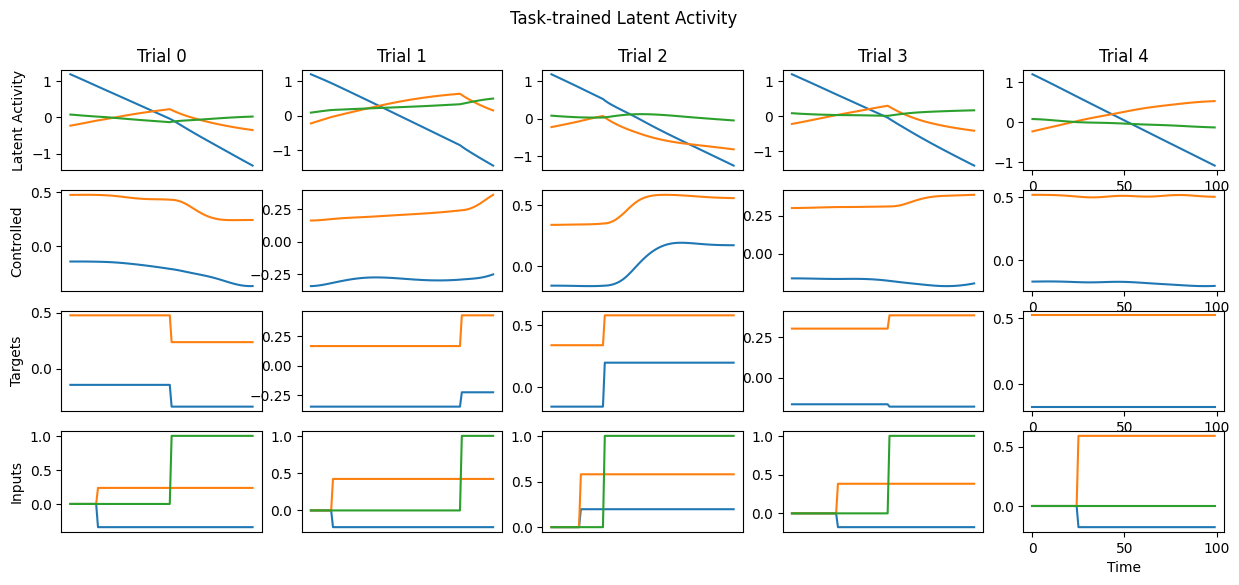

In [8]:
fpath_NODE = HOME_DIR + "models_RT_NODE_3/"

# Create the analysis object:
analysis_NODE = TT_RandomTarget(
    run_name = "NODE_3_RT",
    filepath = fpath_NODE)

analysis_NODE.plot_trial_io(num_trials = 5)

### Checking Affine Transform

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128
target = analysis_NODE

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")

NameError: name 'analysis_GRU_128' is not defined

### Checking PCA


In [10]:
# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

R2 of linear regression fit: [0.8427351  0.9099076  0.82335496 0.87435627 0.6075235  0.68185186
 0.7389512  0.75143445 0.70206034 0.5226852  0.65229976 0.6451189
 0.62511873 0.43030542 0.5346262  0.4422891  0.36522615 0.4084859
 0.43091667 0.41949987 0.2888289  0.31472826 0.24399704 0.23103106
 0.29694957 0.26184058 0.30554628 0.24046135 0.24341226 0.23101938
 0.2678001  0.18815935]
Variance-weighted R2 of linear regression fit: 0.8451516032218933


array([0.36181954, 0.23690103, 0.14403035, 0.10428658, 0.05625831,
       0.02908692, 0.01492349, 0.00952354, 0.00686038, 0.00538731],
      dtype=float32)

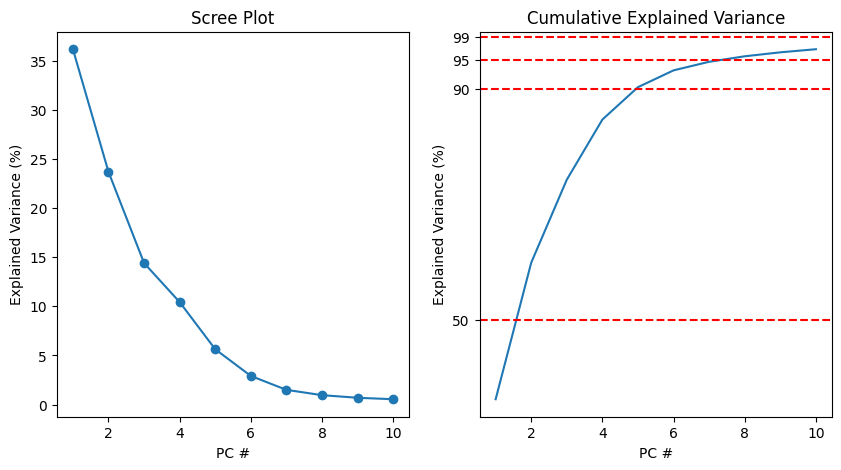

In [11]:
analysis_GRU_128.plot_scree()

array([0.7503384 , 0.14170979, 0.06124982, 0.0158659 , 0.00887754,
       0.0051723 , 0.00437889, 0.00297666, 0.00248997, 0.00200044],
      dtype=float32)

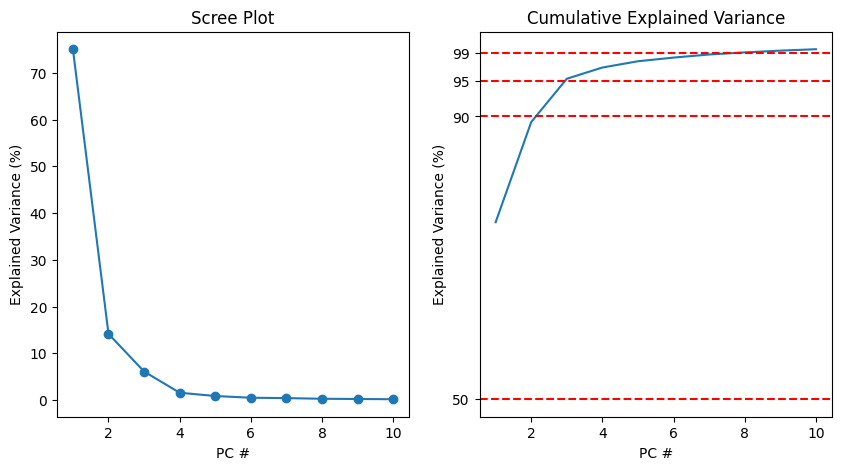

In [12]:
analysis_NODE.plot_scree()

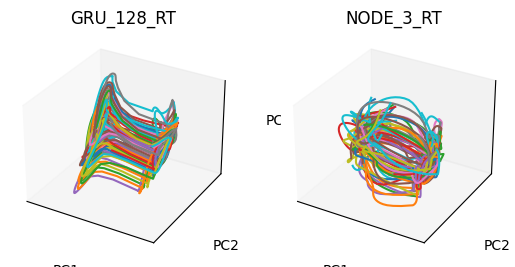

In [13]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=100)

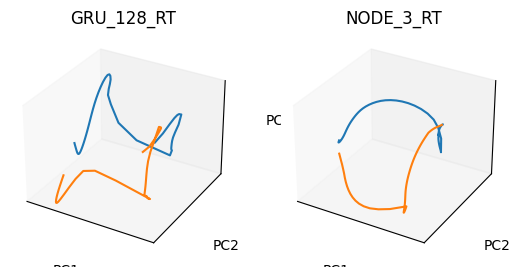

In [14]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=2)

## Fixed point finding

In [34]:
print('Hello world')

Hello world


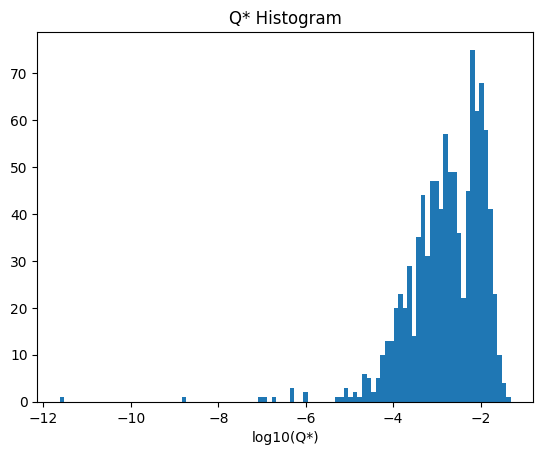

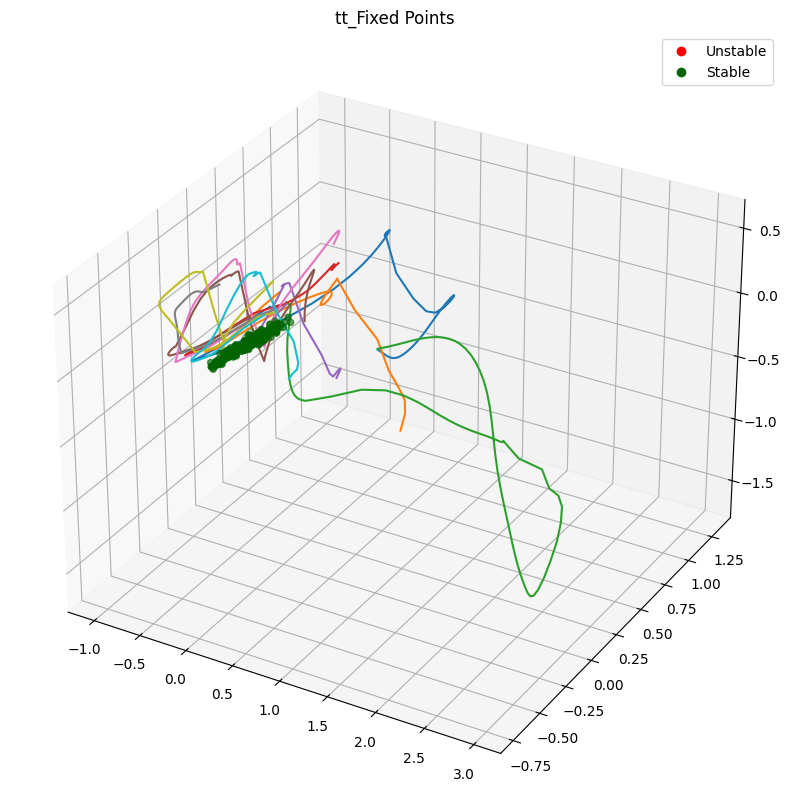

In [35]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-6,
        noise_scale=0.0,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-3,
    )

In [11]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_CO_NODE_128.plot_coupled_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-6,
        noise_scale=0.0,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-3,
    )

TypeError: find_fixed_points_coupled.<locals>.compute_jacobians_func() missing 1 required positional argument: 'x_data'

In [58]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-4,
        noise_scale=0.001,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-3,
    )

NameError: name 'analysis_GRU_128' is not defined

/var/folders/9b/swmkwk292kv02szf2vpn3dww0000gn/T/ipykernel_10284/24356990.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


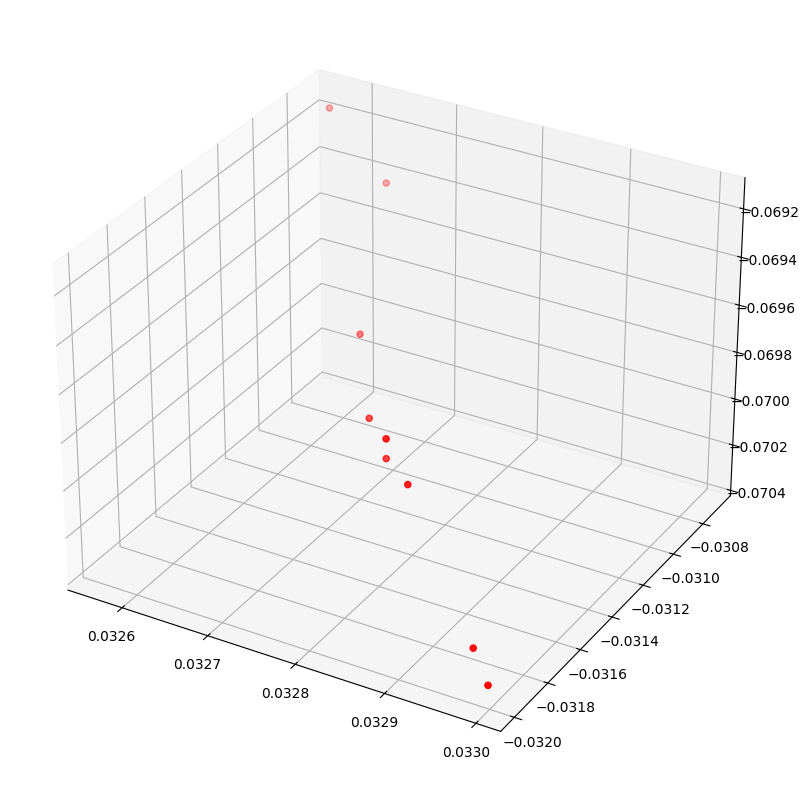

In [36]:
import matplotlib.pyplot as plt
q_thesh = 1e-6
q_vals = fps_gru.qstar
x_star = fps_gru.xstar[q_vals < q_thesh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='r', marker='o')
fig.show()


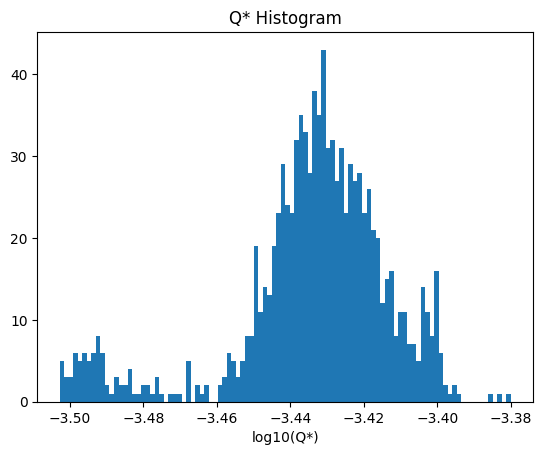

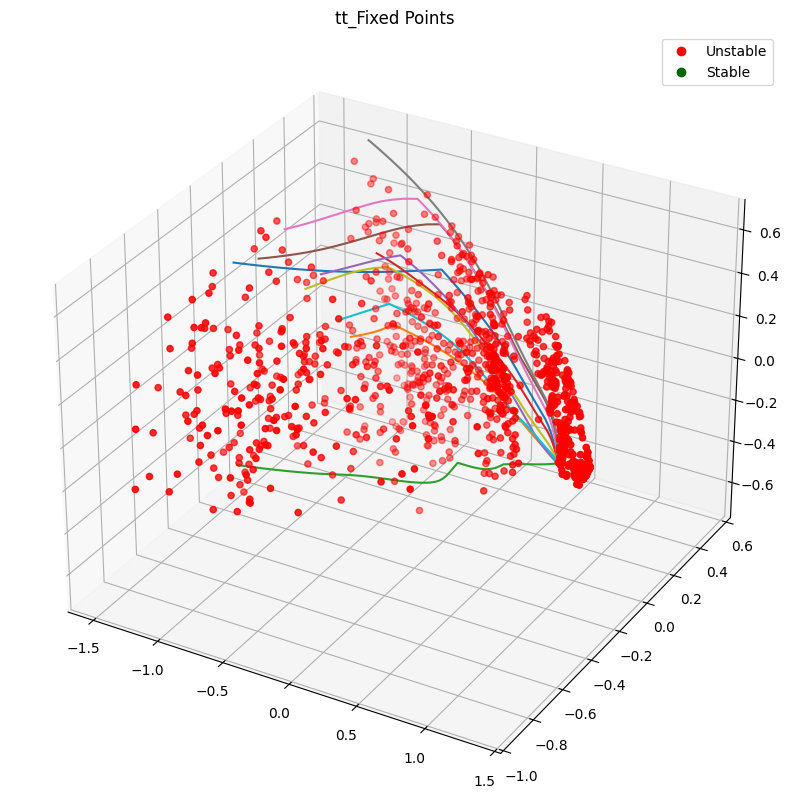

In [37]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_node = analysis_NODE.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-7,
        noise_scale=0.0,
        max_iters=2000000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-3,
    )

/var/folders/9b/swmkwk292kv02szf2vpn3dww0000gn/T/ipykernel_10284/1982500247.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


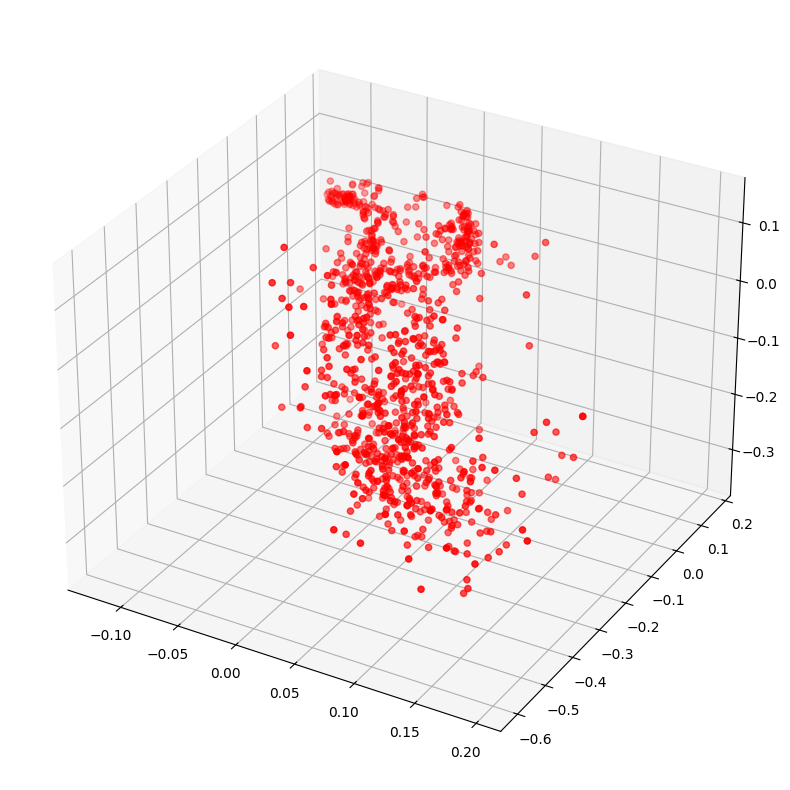

In [50]:
import matplotlib.pyplot as plt
q_thresh = 0.001
q_vals = fps_node.qstar
x_star = fps_node.xstar[q_vals < q_thresh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='r', marker='o')
fig.show()


In [ ]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_GRU_128 = HOME_DIR + "models_RT_GRU_128/"
# Create the analysis object:

analysis_GRU_128 = TT_RandomTarget(
    run_name = "RT_GRU_128",
    filepath = fpath_GRU_128)

analysis_GRU_128.plot_trial(1)

analysis_GRU_128.plot_trial(99)

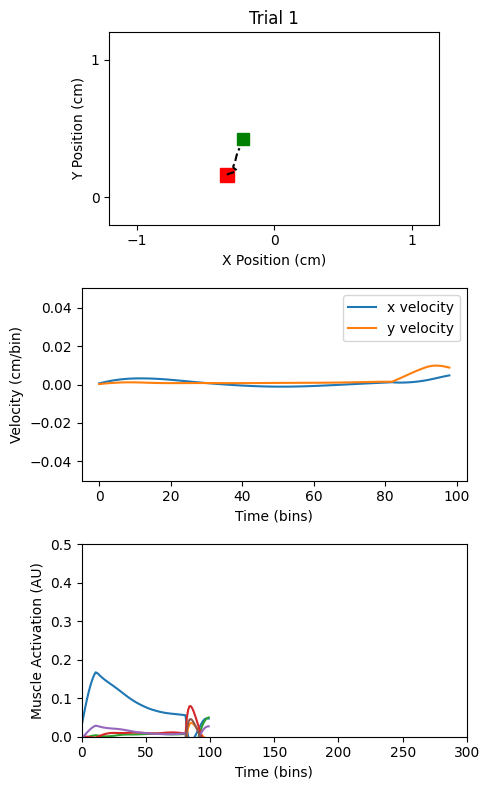

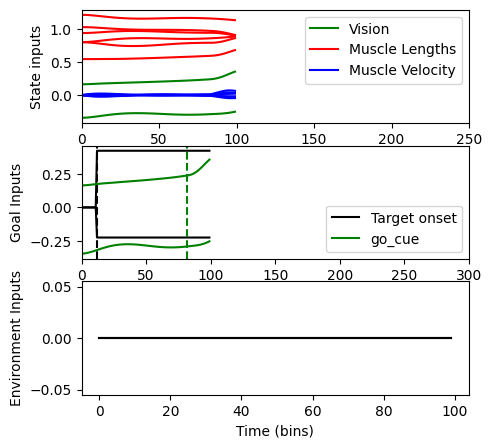

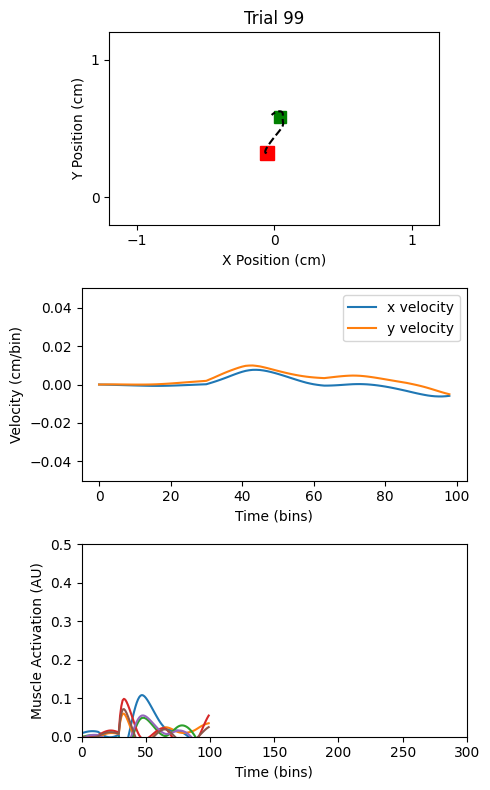

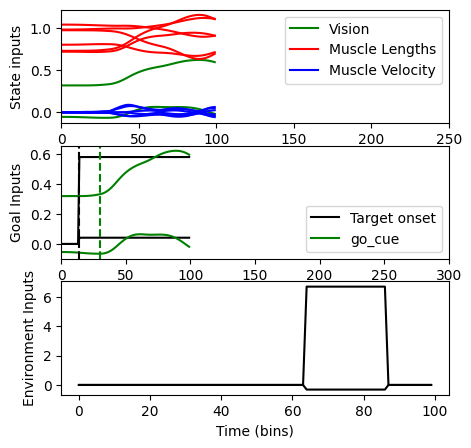

In [20]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_NODE = HOME_DIR + "models_RT_NODE_3/"
# Create the analysis object:

analysis_NODE = TT_RandomTarget(
    run_name = "RT_NODE",
    filepath = fpath_NODE)

analysis_NODE.plot_trial(1)

analysis_NODE.plot_trial(99)

### Try using the coupled fixed point

Importantly, this task is distinct from the previous two tasks because the outputs of the model affect the subsequent inputs!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetIllustration-01.png?raw=true" width="400"/>


Visualizing the latent dynamics of models trained on MotorNet tasks, we can see that there are complex features in the state space, but we'll leave that to you to figure out what they mean!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetGif.gif?raw=true" width="300"/>

In the later questions, we will ask you to modify the environments in MotorNet to test how well your models can generalize to new tasks!

###  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introducing_the_random_target_task")

---
## Conclusion

That's it!

To recap, in this tutorial, we learned:
1. The basics of two tasks, the Three-Bit Flip-Flop and the Random Target task.
2. How to train recurrent neural network models on these tasks
3. Methods of visualizing and quantifying differences between these task-trained models.

As you begin to extend beyond this tutorial, you will likely need to make your own environments, or modify existing environments to test the ability of models to generalize. We've tried to document the code-base to make this as easy as possible, but feel free to reach out if you have any questions!

###  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_conclusion")

In [1]:
print('Hello World') 

Hello World
